# Benchmark Figures on OpenML-CC18

## Setup

In [1]:
import ast
import numpy as np
import openml
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Define color palette
sns.set(
    color_codes=True, palette="bright", style="white", context="talk", font_scale=1.5
)

In [3]:
def plot_acc(col, ls, pos, n_train, lw=5):
    if pos == 0:
        for i, l in enumerate(ls[pos]):
            col.plot(n_train, l, label=legends[i], c=colors[i], lw=lw)
    else:
        for i, l in reversed(list(enumerate(ls[pos]))):
            col.plot(n_train, l, c=colors[i], lw=lw)


def plot_fill(col, rf_ls, sdf_ls, label, n_train):
    if label:
        col.fill_between(
            n_train,
            rf_ls,
            sdf_ls,
            where=sdf_ls >= rf_ls,
            color=colors[0],
            interpolate=True,
            alpha=0.3,
            label=fill_legends[0],
        )
        col.fill_between(
            n_train,
            rf_ls,
            sdf_ls,
            where=sdf_ls <= rf_ls,
            color=colors[1],
            interpolate=True,
            alpha=0.3,
            label=fill_legends[1],
        )
    else:
        col.fill_between(
            n_train,
            rf_ls,
            sdf_ls,
            where=sdf_ls <= rf_ls,
            color=colors[1],
            interpolate=True,
            alpha=0.3,
        )
        col.fill_between(
            n_train,
            rf_ls,
            sdf_ls,
            where=sdf_ls >= rf_ls,
            color=colors[0],
            interpolate=True,
            alpha=0.3,
        )

    return False

In [4]:
directory = "../benchmarks/results/"
prefixes = ["sdf/", "rf/"]
legends = ["SDF", "DF"]
fill_legends = ["SDF wins", "DF wins"]
colors = ["r", "b"]
datasets = openml.study.get_suite("OpenML-CC18").data

max_size = []
num_features = []
num_classes = []
for dataset in datasets:
    data = openml.datasets.get_dataset(dataset, download_data=False)
    max_size.append(round(data.qualities["NumberOfInstances"] * 0.8))
    num_features.append(round(data.qualities["NumberOfFeatures"]) - 1)
    num_classes.append(round(data.qualities["NumberOfClasses"]))

## Plot all accuracy

In [5]:
# Show concatenated time for batch estimators
concat = True

acc_ls = []
time_ls = []
ranges = []
for dataset in datasets:
    acc_l = []
    time_l = []

    for prefix in prefixes:
        f = open(directory + prefix + "cc18_acc.json")
        acc = np.mean(json.load(f)[str(dataset)], axis=0)
        f.close()
        acc_l.append(acc)

        f = open(directory + prefix + "cc18_train_t.json")
        time = np.mean(json.load(f)[str(dataset)], axis=0)
        f.close()

        if concat and prefix == "rf/":
            for j in range(1, len(time)):
                time[j] += time[j - 1]

        time_l.append(time)

    acc_ls.append(acc_l)
    time_ls.append(time_l)
    ranges.append(len(acc_l[0]))

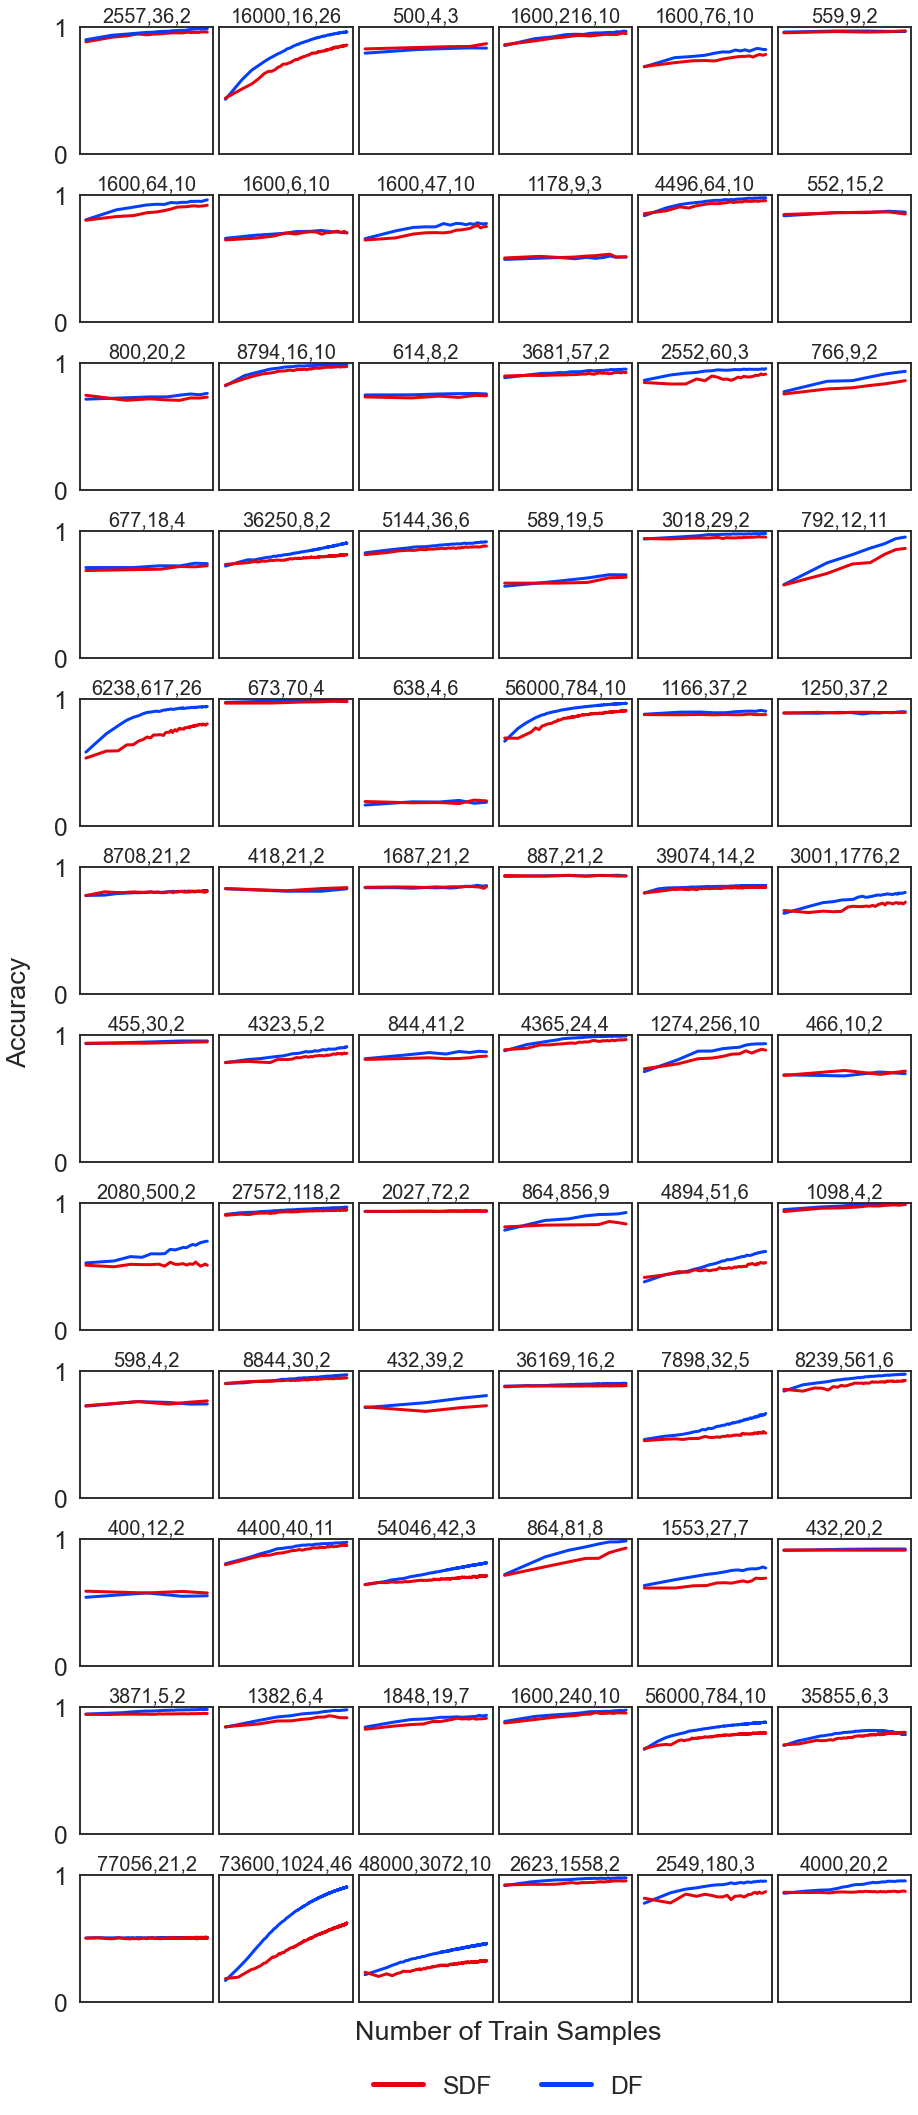

In [6]:
fig, ax = plt.subplots(nrows=12, ncols=6, figsize=(12, 28), constrained_layout=True)
fig.text(0.53, -0.01, "Number of Train Samples", ha="center")
fig.text(-0.05, 0.5, "Accuracy", va="center", rotation="vertical")
ytitles = ["Accuracy", "Wall Time (s)"]
ylimits = [[0, 1], [1e-4, 1e5]]
yticks = [[0, 1], [1e-4, 1e-1, 1e2, 1e5]]

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        count = 6 * i + j
        n_train = range(100, (ranges[count] + 1) * 100, 100)

        # Label x axis and plot figures
        plot_acc(col, acc_ls, count, n_train, lw=3)

        # Adjust x axis
        col.set_xscale("log")
        col.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

        # Adjust y axis
        col.set_ylim(ylimits[0])
        if j == 0:
            col.set_yticks(yticks[0])
        else:
            col.set_yticks([])

        # Adjust overall
        col.set_title(
            str(max_size[count])
            + ","
            + str(num_features[count])
            + ","
            + str(num_classes[count]),
            fontsize=20,
        )


fig.align_ylabels(
    ax[
        :,
    ]
)

leg = fig.legend(
    bbox_to_anchor=(0.53, -0.05),
    bbox_transform=plt.gcf().transFigure,
    ncol=2,
    loc="lower center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.savefig("../paper/cc18.pdf", transparent=True, bbox_inches="tight")

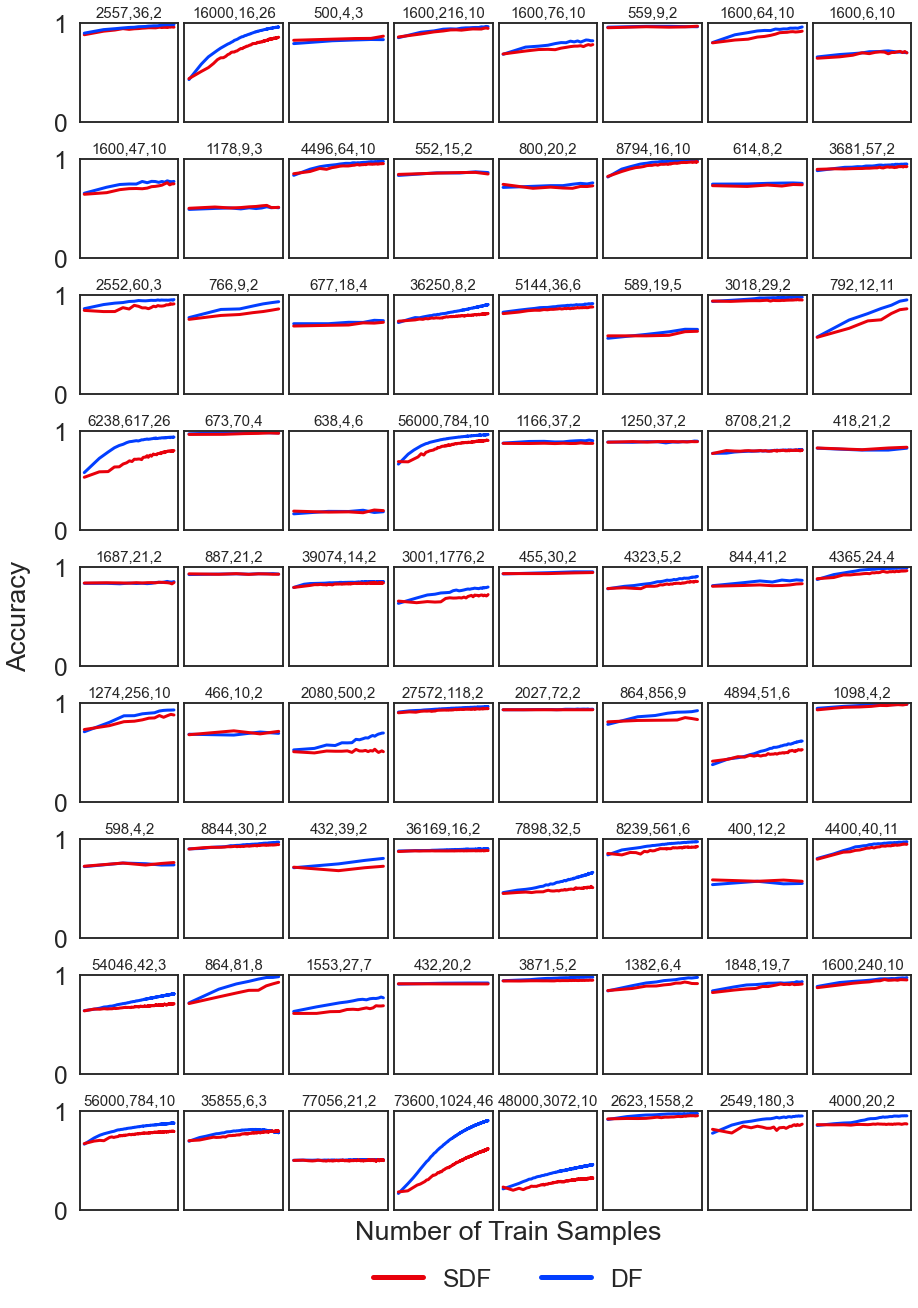

In [7]:
# Plot a wider version
fig, ax = plt.subplots(nrows=9, ncols=8, figsize=(12, 17), constrained_layout=True)
fig.text(0.53, -0.01, "Number of Train Samples", ha="center")
fig.text(-0.05, 0.5, "Accuracy", va="center", rotation="vertical")
ytitles = ["Accuracy", "Wall Time (s)"]
ylimits = [[0, 1], [1e-4, 1e5]]
yticks = [[0, 1], [1e-4, 1e-1, 1e2, 1e5]]

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        count = 8 * i + j
        n_train = range(100, (ranges[count] + 1) * 100, 100)

        # Label x axis and plot figures
        plot_acc(col, acc_ls, count, n_train, lw=3)

        # Adjust x axis
        col.set_xscale("log")
        col.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

        # Adjust y axis
        col.set_ylim(ylimits[0])
        if j == 0:
            col.set_yticks(yticks[0])
        else:
            col.set_yticks([])

        # Adjust overall
        col.set_title(
            str(max_size[count])
            + ","
            + str(num_features[count])
            + ","
            + str(num_classes[count]),
            fontsize=15,
        )


fig.align_ylabels(
    ax[
        :,
    ]
)

leg = fig.legend(
    bbox_to_anchor=(0.53, -0.07),
    bbox_transform=plt.gcf().transFigure,
    ncol=2,
    loc="lower center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.savefig("../paper/cc18_wide.pdf", transparent=True, bbox_inches="tight")

## Plot accuracy (filled) on filtered datasets

In [8]:
rf_acc_dict = json.load(open(directory + "rf/cc18_acc.json"))
sdf_acc_dict = json.load(open(directory + "sdf/cc18_acc.json"))
avg_rf_acc_ls = []
avg_sdf_acc_ls = []

for dataset in datasets:
    avg_rf_acc_l = np.mean(rf_acc_dict[str(dataset)], axis=0)
    avg_rf_acc_ls.append(avg_rf_acc_l)

    avg_sdf_acc_l = np.mean(sdf_acc_dict[str(dataset)], axis=0)
    avg_sdf_acc_ls.append(avg_sdf_acc_l)

avg_rf_acc_ls = np.array(avg_rf_acc_ls, dtype=object)
avg_sdf_acc_ls = np.array(avg_sdf_acc_ls, dtype=object)

In [9]:
ratio_ls = 100 * (avg_sdf_acc_ls - avg_rf_acc_ls) / avg_rf_acc_ls

eff_filter = []
for i in range(len(ratio_ls)):
    if np.amax(ratio_ls[i]) >= 1 and np.amin(ratio_ls[i]) <= -1:
        eff_filter.append(False)
    else:
        eff_filter.append(True)

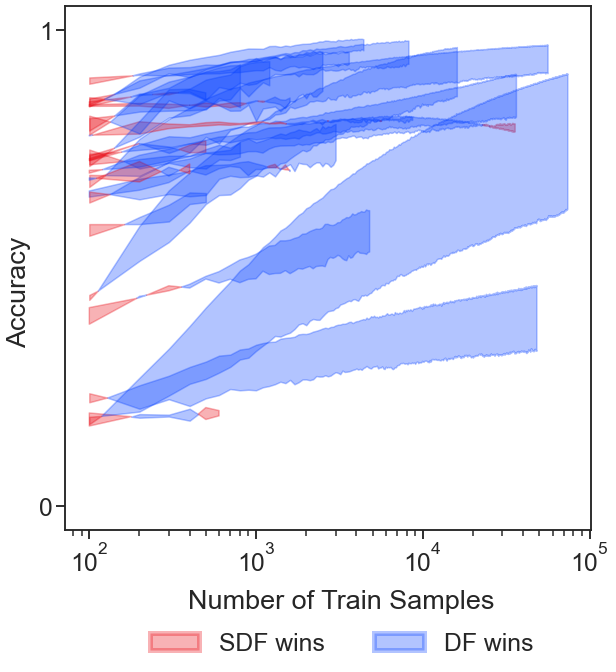

In [10]:
sns.set_theme(style="ticks", palette="bright", context="talk", font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
fig.text(0.53, -0.05, "Number of Train Samples", ha="center")
fig.text(-0.05, 0.5, "Accuracy", va="center", rotation="vertical")
ylimits = [[-0.05, 1.05]]

label = True
for i in range(len(datasets)):
    n_train = range(100, (ranges[i] + 1) * 100, 100)

    if not eff_filter[i]:
        # Label x axis and plot figures
        label = plot_fill(ax, avg_rf_acc_ls[i], avg_sdf_acc_ls[i], label, n_train)

# Adjust x axis
ax.set_xscale("log")

# Adjust y axis
ax.set_ylim(ylimits[0])
ax.set_yticks(yticks[0])

# Adjust overall
leg = fig.legend(
    bbox_to_anchor=(0.53, -0.17),
    bbox_transform=plt.gcf().transFigure,
    ncol=3,
    loc="lower center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.savefig("../paper/cc18_fill.pdf", transparent=True, bbox_inches="tight")